<h1>Campaign Donation Predictor</h1>
<p>This notebook is part one of a mini end-to-end machine learning web application.  The question at hand is whether simple attributes like name and occupation can reveal which 2016 presidential candidate you prefer.  This is the structure:<p>
<ol>
<li> <strong>The notebook (you are here)</strong>: This is where the model is trained using Federal Election Commission data.</li>
<li> <strong>The API</strong>: Using the trained model from part 1 (in Pickle form), a Flask API serves predictions to the front-end.</li>
<li><strong>The web app</strong>: Using the prediction from the API, the app visualizes the results.</li>


In [73]:
# analysis
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn import grid_search
from sklearn.grid_search import GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
import statsmodels.formula.api as smf
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import KFold

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# pickle
import pickle

In [35]:
cols = ["d_id",
        "cand_id",
        "cand_nm",
        "contbr_nm",
        "contbr_city", 
        "contbr_st",
        "contbr_zip",
        "contbr_emp",
        "contbr_occ",
        "contbr_receipt_amt",
        "contbr_contb_receipt_dt",
        "receipt_desc", 
        "memo_cd",
        "memo_text",
        "form_tp",
        "file_num",
        "tran_ud",
        "election",
        "empty"
       ]
df =  pd.read_csv('fec.csv',names=cols,skiprows=[0])
df.head()

,d_id,cand_id,cand_nm,contbr_nm,contbr_city,contbr_st,contbr_zip,contbr_emp,contbr_occ,contbr_receipt_amt,contbr_contb_receipt_dt,receipt_desc,memo_cd,memo_text,form_tp,file_num,tran_ud,election,empty
0,C00458844,P60006723,"Rubio, Marco","HEFFERNAN, MICHAEL",APO,AE,9096,RETIRED,RETIRED,225,29-OCT-15,NaN,NaN,NaN,SA17A,1047126,SA17.863181,P2016,NaN
1,C00458844,P60006723,"Rubio, Marco","HEFFERNAN, MICHAEL",APO,AE,90960009,INFORMATION REQUESTED PER BEST EFFORTS,INFORMATION REQUESTED PER BEST EFFORTS,210,27-JUN-15,NaN,NaN,NaN,SA17A,1029436,SA17.796904,P2016,NaN
2,C00458844,P60006723,"Rubio, Marco","DOHERTY, THERESA",APO,AE,97520002,DODEA/DS,TEACHER,500,26-JUN-15,NaN,NaN,NaN,SA17A,1029436,SA17.769700,P2016,NaN
3,C00458844,P60006723,"Rubio, Marco","KIBBLE, KUMAR",DPO,AE,92131903,U.S. DEPARTMENT OF HOMELAND SECURITY,LAW ENFORCEMENT,500,27-AUG-15,NaN,NaN,NaN,SA17A,1031526,SA17.813360,P2016,NaN
4,C00458844,P60006723,"Rubio, Marco","VERHAGEN, JOSH",NENANA,AK,997600113,U.B.I,CARPENTER,25,18-NOV-15,NaN,NaN,NaN,SA17A,1047126,SA17.879914,P2016,NaN


In [36]:
# Pull out columns needed
desired_cols = ["cand_nm","contbr_nm","contbr_st","contbr_zip","contbr_receipt_amt","contbr_occ"]
df = df[desired_cols]
df.head()

,cand_nm,contbr_nm,contbr_st,contbr_zip,contbr_receipt_amt,contbr_occ
0,"Rubio, Marco","HEFFERNAN, MICHAEL",AE,9096,225,RETIRED
1,"Rubio, Marco","HEFFERNAN, MICHAEL",AE,90960009,210,INFORMATION REQUESTED PER BEST EFFORTS
2,"Rubio, Marco","DOHERTY, THERESA",AE,97520002,500,TEACHER
3,"Rubio, Marco","KIBBLE, KUMAR",AE,92131903,500,LAW ENFORCEMENT
4,"Rubio, Marco","VERHAGEN, JOSH",AK,997600113,25,CARPENTER


In [39]:
# Limit data to 50 U.S. states
states = ["AL","AK","AZ","AR","CA","CO","CT","DE","FL","GA","HI","ID","IL","IN","IA","KS","KY","LA","ME","MD","MA","MI","MN","MS","MO","MT","NE","NV","NH","NJ","NM","NY","NC","ND","OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VT","VA","WA","WV","WI","WY"]
df = df[df.contbr_st.isin(states)]



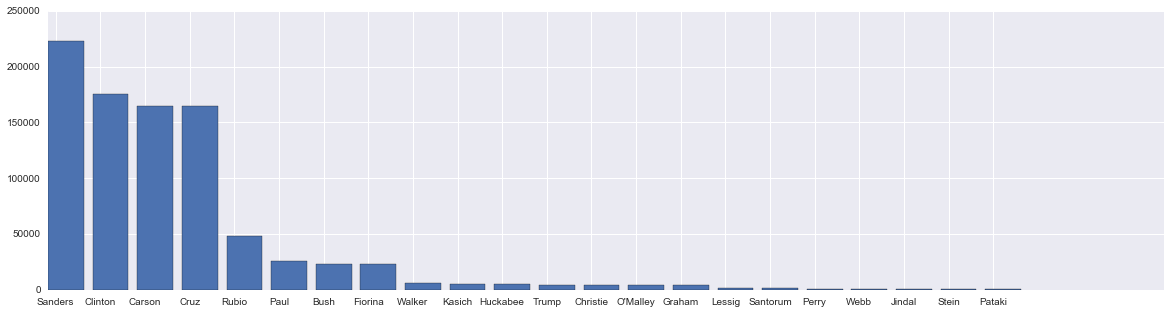

In [31]:
# Explore Candidates by quantity of contirbutions
plt.figure(figsize=(20,5))
OX = df.cand_nm.apply(lambda x: x.split(",")[0]).value_counts().index
OY = df.cand_nm.value_counts()
width = .35
ind = np.arange(len(OY))
plt.bar(ind, OY)
plt.xticks(ind + width / 2, OX)

plt.show()

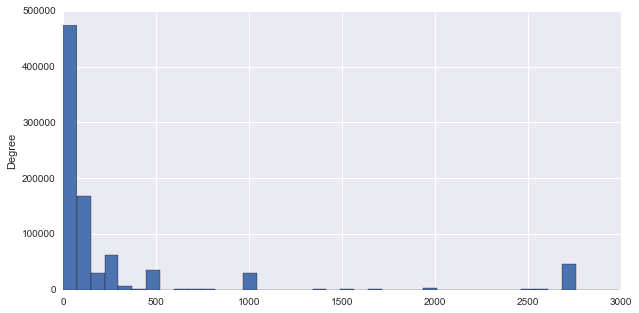

In [38]:
# Explore contribution Sizes via histogram

df = df[(df.contbr_receipt_amt > 0) & (df.contbr_receipt_amt < 3000)] # Remove negative and false large contributions
df.contbr_receipt_amt.plot(kind='hist', alpha=1,bins=40,figsize=(10,5))

# Most contributions are smaller than $100.  A bump exists at $2600 since that is the legal limit. 

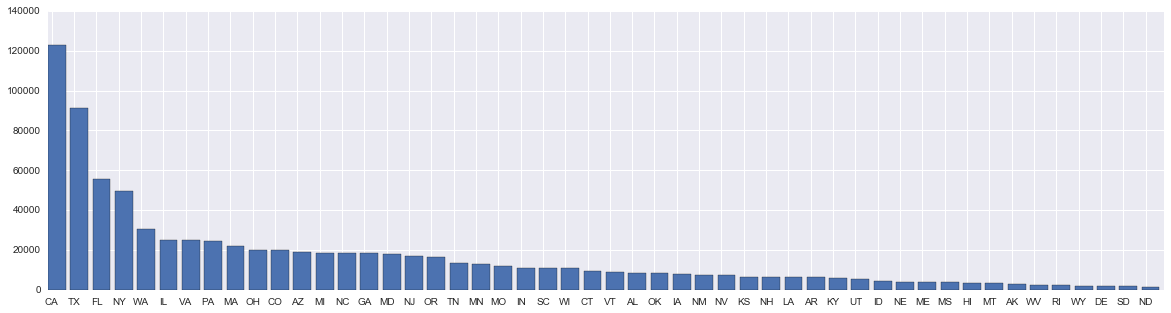

In [9]:
# Explore quantity of contributions by states
plt.figure(figsize=(20,5))
OX = df.contbr_st.value_counts().index

OY = df.contbr_st.value_counts()
width = .35
ind = np.arange(len(OY))
plt.bar(ind, OY)
plt.xticks(ind + width / 2, OX)


plt.show()


In [45]:
# Add first name column

def extract_first_name(data):
    x = data.split(",")
    if len(x) == 1:
        return x[0].split(" ")[0]
    x2 = x[1].split(" ")
    if len(x2) == 1:
        return x2[0]
    return x2[1]

df["first_name"] = df["contbr_nm"].apply(extract_first_name)

# Add  weekday column (removed)

def get_weekday_from_datestring(data):
    return datetime.datetime.strptime(data, "%d-%b-%y").weekday()

# df["weekday"] = df["contbr_contb_receipt_dt"].apply(get_weekday_from_datestring)


In [68]:
# Map Candidate to label

le = LabelEncoder()
le.fit(df['cand_nm'])
df['cand_nm_label'] = le.transform(df['cand_nm'])
le.classes_


array(['Bush, Jeb', 'Carson, Benjamin S.', 'Christie, Christopher J.',
       'Clinton, Hillary Rodham', "Cruz, Rafael Edward 'Ted'",
       'Fiorina, Carly', 'Graham, Lindsey O.', 'Huckabee, Mike',
       'Jindal, Bobby', 'Kasich, John R.', 'Lessig, Lawrence',
       "O'Malley, Martin Joseph", 'Pataki, George E.', 'Paul, Rand',
       'Perry, James R. (Rick)', 'Rubio, Marco', 'Sanders, Bernard',
       'Santorum, Richard J.', 'Stein, Jill', 'Trump, Donald J.',
       'Walker, Scott', 'Webb, James Henry Jr.'], dtype=object)

In [47]:
# Since names, states, and occupations are categorical, they must be replaced with dummy columns. 
# To prevent 1000's of dummy columns for names and occupations, only take top 250 most common of each

common_names = df['first_name'].value_counts()[:250].index.tolist()
common_occupations = df['contbr_occ'].value_counts()[:250].index.tolist()

print "Common Names:"
print sorted(common_names)
print "Common Occupations:"
print sorted(common_occupations)


Common Names:
['AARON', 'ADAM', 'ALAN', 'ALBERT', 'ALEX', 'ALEXANDER', 'ALICE', 'ALLEN', 'AMY', 'ANDREA', 'ANDREW', 'ANGELA', 'ANN', 'ANNA', 'ANNE', 'ANTHONY', 'ARTHUR', 'BARBARA', 'BARRY', 'BEN', 'BENJAMIN', 'BETH', 'BETTY', 'BEVERLY', 'BILL', 'BOB', 'BONNIE', 'BRENDA', 'BRIAN', 'BRUCE', 'BRYAN', 'CARL', 'CAROL', 'CAROLE', 'CAROLYN', 'CATHERINE', 'CATHY', 'CHARLES', 'CHARLOTTE', 'CHERYL', 'CHRIS', 'CHRISTINE', 'CHRISTOPHER', 'CONNIE', 'CRAIG', 'CYNTHIA', 'DALE', 'DAN', 'DANA', 'DANIEL', 'DAVID', 'DAWN', 'DEAN', 'DEBORAH', 'DEBRA', 'DENISE', 'DENNIS', 'DIANA', 'DIANE', 'DIANNE', 'DON', 'DONALD', 'DONNA', 'DORIS', 'DOROTHY', 'DOUG', 'DOUGLAS', 'ED', 'EDWARD', 'EDWIN', 'EILEEN', 'ELAINE', 'ELEANOR', 'ELIZABETH', 'ELLEN', 'EMILY', 'ERIC', 'EUGENE', 'EVELYN', 'FRANCES', 'FRANCIS', 'FRANK', 'FRED', 'FREDERICK', 'GAIL', 'GARY', 'GENE', 'GEORGE', 'GERALD', 'GLENN', 'GLORIA', 'GORDON', 'GREG', 'GREGORY', 'HAROLD', 'HARRY', 'HEATHER', 'HELEN', 'HENRY', 'HOWARD', 'J.', 'JACK', 'JACQUELINE', 'JAM

In [48]:
# Values for name and occupation that are not common are made null
df['first_name'] = df['first_name'].apply(lambda x: x if x in common_names else np.nan)
df['contbr_occ'] = df['contbr_occ'].apply(lambda x: x if x in common_occupations else np.nan)
df.head(10)

,cand_nm,contbr_nm,contbr_st,contbr_zip,contbr_receipt_amt,contbr_occ,cand_nm_label,first_name
4,"Rubio, Marco","VERHAGEN, JOSH",AK,997600113,25,CARPENTER,15,NaN
5,"Rubio, Marco","VERHAGEN, JOSH",AK,997600113,17,CARPENTER,15,NaN
6,"Rubio, Marco","VERHAGEN, JOSH",AK,997600113,25,CARPENTER,15,NaN
7,"Rubio, Marco","HINES, SCOT",AK,995165437,100,HEALTH CARE,15,NaN
8,"Rubio, Marco","HINES, SCOT",AK,995165437,100,HEALTH CARE,15,NaN
9,"Rubio, Marco","HINES, SCOT",AK,995165437,100,HEALTH CARE,15,NaN
10,"Rubio, Marco","JANELLI, REBECCA T",AK,995076742,100,RETIRED,15,REBECCA
11,"Rubio, Marco","JANELLI, REBECCA T",AK,995076742,100,RETIRED,15,REBECCA
12,"Rubio, Marco","JANELLI, REBECCA T",AK,995076742,100,RETIRED,15,REBECCA
13,"Rubio, Marco","LEONARD, JOAN MS.",AK,997050258,25,RETIRED,15,JOAN


In [49]:
# Make dummy columns for first name, state, and occupation
first_name_dummies = pd.get_dummies(df['first_name'],prefix='n_')
contbr_st_dummies = pd.get_dummies(df['contbr_st'],prefix='s_')
contbr_occ_dummies = pd.get_dummies(df['contbr_occ'],prefix='o_')

df = pd.concat([df, first_name_dummies ,contbr_st_dummies,contbr_occ_dummies], axis=1)

In [50]:
df.shape 
#558 Columns (250 from dummy names, 250 from dummy occs, 50 states, 8 extras)

(860598, 558)

In [65]:
# Build final X and y
y = df.cand_nm_label

X_columns = ['contbr_receipt_amt'] \
+ list(contbr_occ_dummies.columns.values) \
+ list(contbr_st_dummies.columns.values) \
+ list(first_name_dummies.columns.values)

X =df[X_columns]


In [66]:
# Split data into train and test and train RFC on training data

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)
rfc = RandomForestClassifier(n_estimators=5,n_jobs=-1)
rfc.fit(X_train,y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [ ]:
# Run GridSearch within training set to pick optimal hyperparamters
rfc_pipeline = Pipeline([('clf', RandomForestClassifier(n_estimators=5))])
rfc_parameters = {'clf__bootstrap':[True,False],
                'clf__class_weight' : [None,"balanced"]
                 }

rfc_gs = GridSearchCV(rfc_pipeline, rfc_parameters,cv=KFold(n = len(X_train), n_folds=3,shuffle=True,random_state=42), n_jobs=-1)

# Fit the training data to the learner
rfc_gs = rfc_gs.fit(X_train,y_train)
rfc_gs.best_params_


{'clf__bootstrap': False}

In [84]:
# Report Score
rfc_gs.score(X_test,y_test)

################################
# Variation Scores:
################################
# Score with State, First Name, Occ, Amount Donated ~55
# Score Without Amount Donated ~52
# Score without First Name ~48
# Score Without Occupation ~46
# Score Without State ~44
################################
# Score With RFC with 100 estimators ~55
# Score With RFC with 10 estimators ~54.5
# Score With RFC with 5 estimators ~54.5
# Score With RFC with 1 estimators ~50.6
################################
# Score With ONLY State ~33
################################
# Score With All Fields After Adding Day Of Week ~ 49 ???
################################
# Score WIth 250 dummy columns instead of 100 for both name and occupation - 59


0.62337410826836803

In [20]:
rfc.get_params()

{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 5,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [21]:

param_grid = {
#                 "max_depth": [3, None],
#               "max_features": [1, 3, 10],
#               "min_samples_split": [1, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
              "n_estimators": [1, 2]}
gs = GridSearchCV(RandomForestClassifier(), param_grid=param_grid,cv=3,n_jobs=-1)
gs.fit(X, y)
# gs.score(X_test,y_test)

#Other things to do.
#1. add headers across the baord
#2. clean grid search square
#3. make function that transforms occupations
#4 adjust plot at the top
#5. new pickle

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_estimators': [1, 2]}, pre_dispatch='2*n_jobs',
       refit=True, scoring=None, verbose=0)

In [22]:
gs.get_params()

{'cv': 3,
 'error_score': 'raise',
 'estimator': RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=None, max_features='auto', max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
             oob_score=False, random_state=None, verbose=0,
             warm_start=False),
 'estimator__bootstrap': True,
 'estimator__class_weight': None,
 'estimator__criterion': 'gini',
 'estimator__max_depth': None,
 'estimator__max_features': 'auto',
 'estimator__max_leaf_nodes': None,
 'estimator__min_samples_leaf': 1,
 'estimator__min_samples_split': 2,
 'estimator__min_weight_fraction_leaf': 0.0,
 'estimator__n_estimators': 10,
 'estimator__n_jobs': 1,
 'estimator__oob_score': False,
 'estimator__random_state': None,
 'estimator__verbose': 0,
 'estimator__warm_start': False,
 'fit_params': {},
 'iid': True,
 'n_jobs': -1,
 'param_grid': {'n_estimators': [1, 2]},


In [23]:
print gs.grid_scores_
print gs.best_estimator_
print gs.best_score_



[mean: 0.28599, std: 0.06977, params: {'n_estimators': 1}, mean: 0.27280, std: 0.07082, params: {'n_estimators': 2}]
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
0.285991828945


In [24]:
# Dummy Score

dumb = DummyClassifier(strategy='most_frequent') # also try with 'stratified'
dumb.fit(X_train, y_train)
y_dumb_class = dumb.predict(X_test) #X_test[:,None]

print ('Accuracy Score:', accuracy_score(y_test, y_dumb_class))

('Accuracy Score:', 0.26956198546765531)


In [25]:
# Refit with entire dataset
rfc.fit(X,y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [26]:
def format_prediction(name,state,occupation,howmuch):
    formatted  = np.zeros(551)
    formatted[0] = howmuch
    
    name_col = "n__" +  name
    occupation_col = "o__" +  occupation
    state_col = "s__" +  state
    if name_col in list(X.columns.values):
        name_dummy = list(X.columns.values).index(name_col)
        formatted[name_dummy] = 1
    if name_col in list(X.columns.values):
        occupation_dummy = list(X.columns.values).index(occupation_col)
        formatted[occupation_dummy] = 1
    if state_col in list(X.columns.values):
        state_dummy = list(X.columns.values).index(state_col)
        formatted[state_dummy] = 1          
    
    return formatted

In [27]:
print "*"*50 
details_1 = [format_prediction("JOHN","NY","BANKER",25)]
details_2 = [format_prediction("JOHN","NY","STUDENT",25)]
print le.inverse_transform(rfc.predict(details_1))[0]
print le.inverse_transform(rfc.predict(details_2))[0]
print "*"*50

details_3 = [format_prediction("BILL","TX","VICE PRESIDENT",2600)]
details_4 = [format_prediction("ANN","TX","VICE PRESIDENT",2600)]
print le.inverse_transform(rfc.predict(details_3))[0]
print le.inverse_transform(rfc.predict(details_4))[0]
print "*"*50

details_5 = format_prediction("JANE","FL","R.N.",1000)]
details_6 = format_prediction("JANE","FL","R.N.",10)
print le.inverse_transform(rfc.predict(details_5))[0]
print le.inverse_transform(rfc.predict(details_6))[0]
print "*"*50

details_7 = format_prediction("LAURA","IL","BANKER",50)
details_8 = format_prediction("LAURA","VT","BANKER",50)
print le.inverse_transform(rfc.predict(details_7))[0]
print le.inverse_transform(rfc.predict(details_8))[0]
print "*"*50



SyntaxError: invalid syntax (<ipython-input-27-2ce279009ddd>, line 14)

In [ ]:
# Get all the percentages for a given prediction
cands = le.inverse_transform(rfc.classes_)
details_test= format_prediction("LAURA","VT","BANKER",50)
print le.inverse_transform(rfc.predict(details_test))[0]
[cands[i]+": " +str(p) for i,p in enumerate(rfc.predict_proba(details_test)[0])]

In [ ]:
Dump to pickle:
    
# pickle.dump(rfc,open("rfc.pkl","wb"))